In [157]:
# imports

import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#from matplotlib.pyplot import plt
import nltk
#nltk.download('wordnet')
#nltk.download('punkt')
#!pip install wordcloud
import nltk
from nltk.stem import WordNetLemmatizer
#from wordcloud import WordCloud


     |████████████████████████████████| 365 kB 13.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


### Important Functions

In [124]:
# read data

def read_data(filename):
    data  = pd.read_csv(filename, lineterminator='\r', encoding = 'latin-1')
    return data

In [125]:
# clean text

def clean_text(tweet):
    tweet = tweet.lower() #lower case
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)  #punctuation
    tweet = re.sub('\d', '', tweet) # number
    #tweet = re.sub('\w*\d\w*', '', tweet) #alphanumeric
    return tweet
    
firstpass = lambda x:clean_text(x)    

In [126]:
# clean text based on specific words

def clean_text_specific(data, wordList):
    for i in range(len(wordList)):
        data = data[data.index != wordList[i]]
    return data

In [127]:
# for combining all text of one particular topic

def combine_target(df, target):
    
    text1 = ""
    text2 = ""
    text3 = ""
    df1 = df.loc[(df['Target'] == target) & (df['Stance'] == "AGAINST") ]
    for i in df1.Tweet:
        text1 = text1 + ' ' + i;
        
    df2 = df.loc[(df['Target'] == target) & (df['Stance'] == "FAVOR") ]
    for i in df2.Tweet:
        text2 = text2 + ' ' + i;   
        
    df3 = df.loc[(df['Target'] == target) & (df['Stance'] == "NONE") ]
    for i in df3.Tweet:
        text3 = text3 + ' ' + i;  
    
    return text1, text2, text3   

In [128]:
# function to create corpus

def create_corpus(data):
    tempdict = {}
    for i in range(5):
        text1, text2, text3 =  combine_target(data, data.Target.unique()[i])
        tempdict[data.Target.unique()[i] + " (Against)"] = text1
        tempdict[data.Target.unique()[i] + " (Favour)"] = text2
        tempdict[data.Target.unique()[i] + " (None)"] = text3
        corpusData = pd.DataFrame(tempdict.items(), columns=['topic', 'tweet'])
    return corpusData

In [129]:
# function to create document term matrix

def create_matrix(data, stop_words, check):
    data.index = data.topic
    if(check):
        cv = CountVectorizer(stop_words=stop_words)
    else:
        cv = CountVectorizer(stop_words="english")
    data_cv = cv.fit_transform(data.tweet)
    data_matrix = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_matrix.index = data.index
    return data_matrix

In [130]:
# display most frequent words in each category

def display_frequent_words(data):
    data = data.transpose()
    top_dict = {}
    for i in data.columns:
        top = data[i].sort_values(ascending = False).head(30)
        top_dict[i] = list(zip(top.index, top.values))
    
    return top_dict

In [131]:
# display unique words

def display_unique_words(data):
    l = {}
    uniqueCount = 0;
    for i in data.columns:
        for j in range(data.shape[0]):
            if(data[i][j] == 1):
                uniqueCount = uniqueCount + 1
        l[i] = uniqueCount
        uniqueCount = 0
    print("Unique words in each topic : ")
    print(l)
    return l

In [132]:
def display_total_words(data):
    l = {}
    uniqueCount = 0;
    for i in data.columns:
        for j in range(data.shape[0]):
            if(data[i][j] >= 1):
                uniqueCount = uniqueCount + 1
        l[i] = uniqueCount
        uniqueCount = 0
    print("Total words in each topic : ")
    print(l)
    return l

In [133]:
# lematization

def lematization(sentence):
    word_list = nltk.word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [134]:
def remove_stopwords(sentence):
    word_list = nltk.word_tokenize(sentence)
    without_stopwords = ' '.join([word for word in word_list if word not in stop_words])
    return without_stopwords

In [135]:
orignaltrainData = read_data("train.csv")  # train data
orignaltestData = read_data("test.csv")  # test data

In [136]:
orignaltrainData.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [137]:
orignaltestData.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [138]:
print(orignaltrainData.shape)
print(orignaltestData.shape)

(2914, 5)
(1956, 5)


In [139]:
# removing unnessary columns
trainData = orignaltrainData.drop(columns=['Opinion Towards','Sentiment'])
testData = orignaltestData.drop(columns=['Opinion Towards','Sentiment'])

In [140]:
# first pass of data cleaning to remove punctuations and digits

trainData.Tweet = pd.DataFrame(trainData.Tweet.apply(firstpass))
testData.Tweet = pd.DataFrame(orignaltestData.Tweet.apply(firstpass))

In [149]:
# creating corpus

corpusData = create_corpus(trainData)

In [150]:
corpusData

,topic,tweet
0,Hillary Clinton (Against),tedcruz handovertheserver wiped clean k delet...
1,Hillary Clinton (Favour),best choice truly want continue progressive n...
2,Hillary Clinton (None),portiaaboulger thank adding list respect law ...
3,Legalization of Abortion (Against),laid law abortion bioethics class catholic do...
4,Legalization of Abortion (Favour),tooprettyclub ok gop male telling body lmao s...
5,Legalization of Abortion (None),isnt problem faith gaystapo socialism meeting...
6,Atheism (Against),dear lord thank u ur blessing forgive sin lor...
7,Atheism (Favour),scoc ruled canadian freedom religion tell har...
8,Atheism (None),wow unsubstantiated claim spook remember whe ...
9,Climate Change is a Real Concern (Against),climate change disgusting asshole money trans...


In [151]:
# creating document term matrix

matrixData = create_matrix(corpusData,"null", False)

In [152]:
matrixData

,aaaalll,aaigh,aamirkhan,aaron,aaronblakewp,ab,abandon,abbeysaurusrex,abbot,abbswinston,...,zelda,zerlinamaxwell,zero,zerofootprint,zip,zmanoj,zoe,zombieneith,zubair,óchristopher
topic,,,,,,,,,,,,,,,,,,,,,
Hillary Clinton (Against),0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Hillary Clinton (Favour),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hillary Clinton (None),0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Legalization of Abortion (Against),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Legalization of Abortion (Favour),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Legalization of Abortion (None),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atheism (Against),0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
Atheism (Favour),0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Atheism (None),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [153]:
commonWords = display_frequent_words(matrixData)

In [154]:
Counter(commonWords).most_common()

[('Feminist Movement (Favour)',
  [('woman', 78),
   ('feminist', 40),
   ('men', 27),
   ('dont', 20),
   ('equality', 20),
   ('need', 18),
   ('want', 18),
   ('right', 18),
   ('man', 17),
   ('female', 15),
   ('equal', 15),
   ('girl', 14),
   ('yesallwomen', 14),
   ('gender', 12),
   ('feminism', 11),
   ('male', 10),
   ('know', 9),
   ('make', 9),
   ('let', 9),
   ('doesnt', 9),
   ('ugly', 9),
   ('time', 8),
   ('called', 7),
   ('think', 7),
   ('heforshe', 6),
   ('stop', 6),
   ('world', 6),
   ('guy', 6),
   ('life', 6),
   ('say', 5)]),
 ('Legalization of Abortion (Favour)',
  [('woman', 38),
   ('right', 30),
   ('abortion', 30),
   ('know', 17),
   ('body', 17),
   ('dont', 16),
   ('choice', 16),
   ('want', 13),
   ('life', 11),
   ('pregnant', 10),
   ('baby', 10),
   ('whats', 9),
   ('best', 9),
   ('health', 7),
   ('rapeculture', 7),
   ('scotus', 6),
   ('prochoice', 6),
   ('womensrights', 6),
   ('choose', 5),
   ('away', 5),
   ('mean', 5),
   ('men', 5),

In [155]:
# Second pass of cleaning since we have realised there are many words that repeat in each category hence 
# they are not important for us, we will just add them in our list of stopwords


# Words to remove from train data
# semst, hillaryclinton, hillary, clinton, just, rt, just, im, people, like

add_stop_words = ['semst', 'hillaryclinton', 'hillary', 'clinton', 'rt', 'just', 'im', 'people','like']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
trainData.Tweet = trainData.Tweet.apply(remove_stopwords)

In [156]:
# Lemarization

lemmatizer = WordNetLemmatizer()
trainData.Tweet = trainData.Tweet.apply(lematization)

### Visualisation Part

In [24]:
# Hypothesis 1 : What are the most common words used in each target category and also what common words used for each
# stance type in each target category

In [ ]:
wc = WordCloud(stopwords = stop_words, background_color="white", colormap = "Dark2", max_font_size =150,
              random_state=42)

In [ ]:
corpusData.head()

In [ ]:
import matplotlib.pyplot as plt

data = corpusData.drop(columns=['topic'])
plt.rcParams['figure.figsize'] = [30, 30]

topics = ['Hillary Clinton (Agaisnt)', 'Hillary Clinton (Favour)', 'Hillary Clinton (Neutral)',
          'Legalization of Abortion (Agaisnt)', 'Legalization of Abortion (Favour)', 'Legalization of Abortion (Neutral)',
          'Atheism (Agaisnt)', 'Atheism (Favour)', 'Atheism (Neutral)',
          'Climate Change is a Real Concern (Agaisnt)','Climate Change is a Real Concern (Favour)', 'Climate Change is a Real Concern (Neutral)',
          'Feminist Movement (Agaisnt)', 'Feminist Movement (Favour)', 'Feminist Movement (Neutral)']

for index in range(data.shape[0]):
    
    wc.generate(data.tweet[index])
    plt.subplot(5,3, index+1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(topics[index])
    
plt.show()

In [25]:
# Hypothesis 1 results

In [26]:
# Hypthesis 2 : How many examples of each topic do we have?

Stance
AGAINST    1395
FAVOR       753
NONE        766
Name: Target, dtype: int64


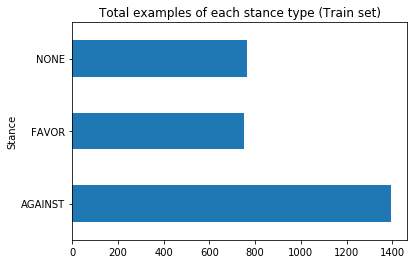

In [80]:
import matplotlib.pyplot as plt
print(trainData.groupby('Stance')['Target'].count())
trainData.groupby('Stance')['Target'].count().plot(kind='barh', title ="Total examples of each stance type (Train set)")
plt.show()

Stance
AGAINST    1014
FAVOR       452
NONE        490
Name: Target, dtype: int64


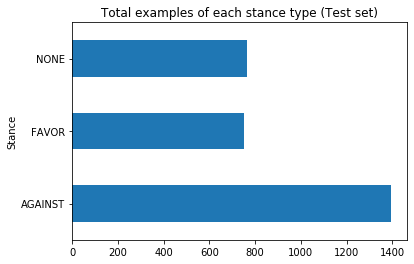

In [81]:
print(testData.groupby('Stance')['Target'].count())
ax = trainData.groupby('Stance')['Target'].count().plot(kind='barh', title ="Total examples of each stance type (Test set)")
plt.show()

Target
Atheism                             513
Climate Change is a Real Concern    395
Feminist Movement                   664
Hillary Clinton                     689
Legalization of Abortion            653
Name: Tweet, dtype: int64


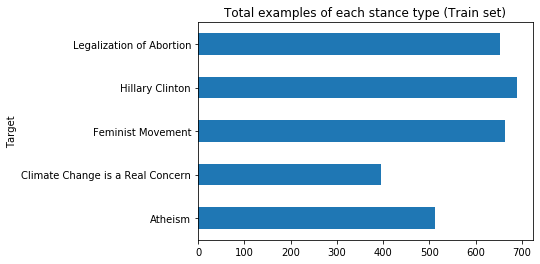

In [82]:
print(trainData.groupby('Target')['Tweet'].count())
trainData.groupby('Target')['Tweet'].count().plot(kind='barh', title ="Total examples of each stance type (Train set)")
plt.show()

Target
Atheism                             220
Climate Change is a Real Concern    169
Donald Trump                        707
Feminist Movement                   285
Hillary Clinton                     295
Legalization of Abortion            280
Name: Tweet, dtype: int64


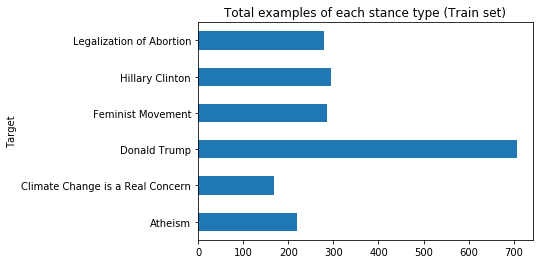

In [83]:
print(testData.groupby('Target')['Tweet'].count())
testData.groupby('Target')['Tweet'].count().plot(kind='barh', title ="Total examples of each stance type (Train set)")
plt.show()

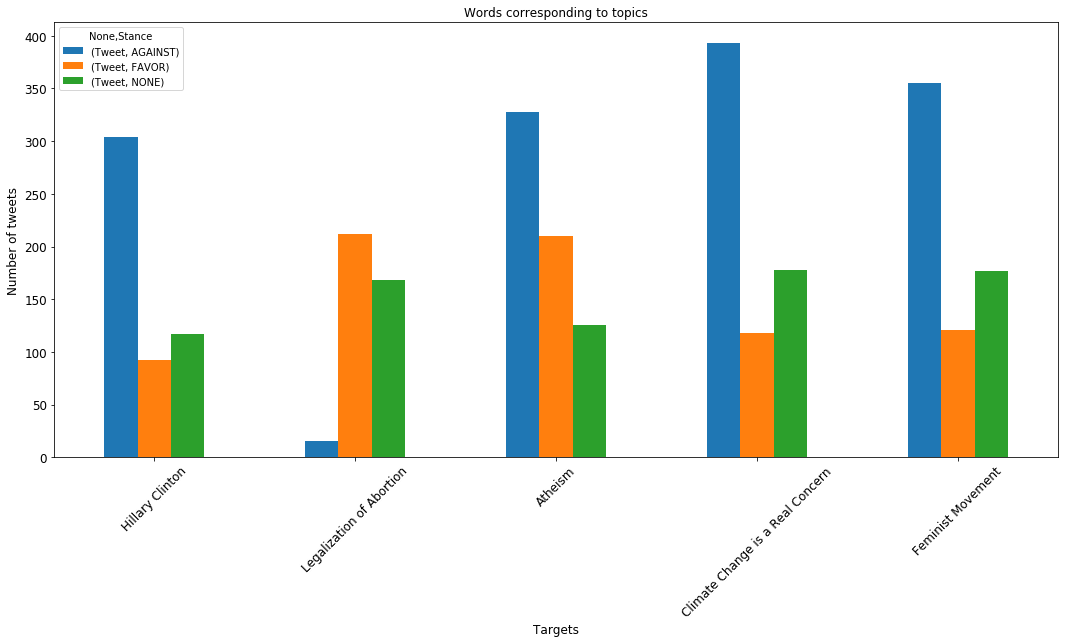

In [93]:
ax = trainData.groupby(['Target','Stance']).count().unstack().plot(kind='bar', title ="Words corresponding to topics", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Targets", fontsize=12)
ax.set_ylabel("Number of tweets", fontsize=12)
ax.set_xticklabels(labels = trainData.Target.unique(),fontsize=12, rotation=45)
plt.show()

In [33]:
# Hypthesis 2 : How many unique and total words used in each stance category of target topic

# we have unbalanaced classes

In [34]:
dict_unique = display_unique_words(matrixData.transpose())

Unique words in each topic : 
{'Hillary Clinton (Against)': 1416, 'Hillary Clinton (Favour)': 445, 'Hillary Clinton (None)': 788, 'Legalization of Abortion (Against)': 1109, 'Legalization of Abortion (Favour)': 432, 'Legalization of Abortion (None)': 898, 'Atheism (Against)': 1032, 'Atheism (Favour)': 453, 'Atheism (None)': 604, 'Climate Change is a Real Concern (Against)': 98, 'Climate Change is a Real Concern (Favour)': 1026, 'Climate Change is a Real Concern (None)': 848, 'Feminist Movement (Against)': 1208, 'Feminist Movement (Favour)': 845, 'Feminist Movement (None)': 702}


In [35]:
dict_total = display_total_words(matrixData.transpose())

Total words in each topic : 
{'Hillary Clinton (Against)': 1912, 'Hillary Clinton (Favour)': 590, 'Hillary Clinton (None)': 999, 'Legalization of Abortion (Against)': 1555, 'Legalization of Abortion (Favour)': 594, 'Legalization of Abortion (None)': 1111, 'Atheism (Against)': 1383, 'Atheism (Favour)': 583, 'Atheism (None)': 755, 'Climate Change is a Real Concern (Against)': 115, 'Climate Change is a Real Concern (Favour)': 1288, 'Climate Change is a Real Concern (None)': 1045, 'Feminist Movement (Against)': 1631, 'Feminist Movement (Favour)': 1090, 'Feminist Movement (None)': 842}


In [36]:
df = pd.DataFrame(columns=['Topics','Total_words', 'Total_unique_words'])
df.Total_words = dict_total.values()
df.Topics = dict_total.keys()
df.Total_unique_words = dict_unique.values()

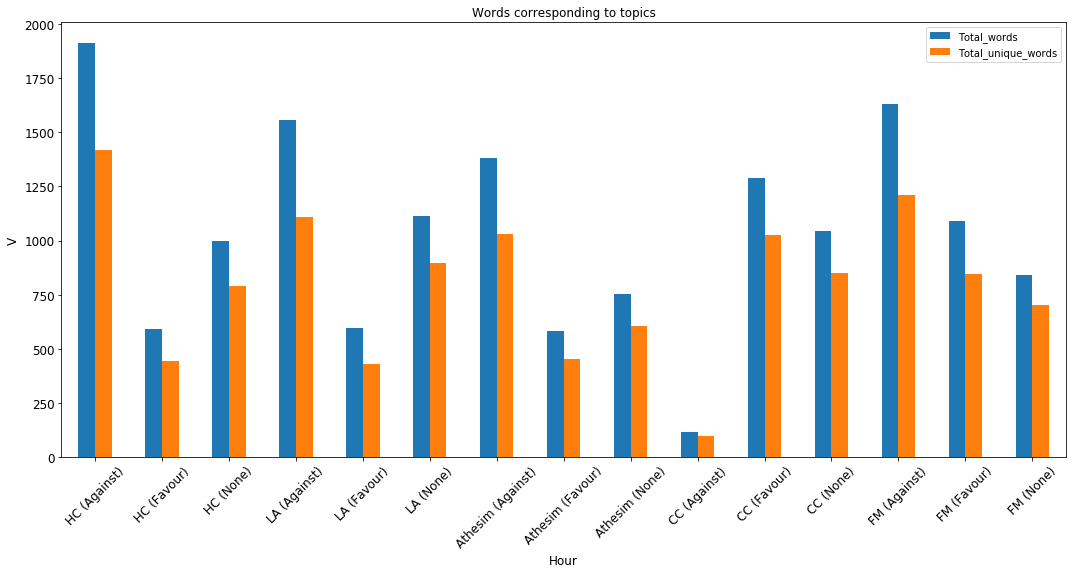

In [37]:
import matplotlib.pyplot as plt
ax = df[['Total_words','Total_unique_words']].plot(kind='bar', title ="Words corresponding to topics", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("V", fontsize=12)
ax.set_xticklabels(['HC (Against)','HC (Favour)', 'HC (None)', 'LA (Against)', 'LA (Favour)', 'LA (None)','Athesim (Against)',
                   'Athesim (Favour)', 'Athesim (None)', 'CC (Against)', 'CC (Favour)', 'CC (None)', 'FM (Against)', 
                    'FM (Favour)','FM (None)'], fontsize=12, rotation=45)
plt.show()

In [39]:
# Hypothesis 2 results

In [40]:
# using original dataframe with all the columns intact to find correlation among columns

# Hypothesis 3 : Does sentiments and stance have some sort of correlation with each other?

In [41]:
orignaltrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            2914 non-null   object
 1   Target           2914 non-null   object
 2   Stance           2914 non-null   object
 3   Opinion Towards  2914 non-null   object
 4   Sentiment        2914 non-null   object
dtypes: object(5)
memory usage: 114.0+ KB


In [42]:
orignaltrainData.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,Tweet,Target,Stance,Opinion Towards,Sentiment
Tweet,1.000000,-0.433538,-0.108482,-0.083260,-0.168079
Target,-0.433538,1.000000,0.080522,-0.039359,-0.008741
Stance,-0.108482,0.080522,1.000000,0.460886,0.157621
Opinion Towards,-0.083260,-0.039359,0.460886,1.000000,0.111270
Sentiment,-0.168079,-0.008741,0.157621,0.111270,1.000000


In [43]:
# Hypothesis 3 Result : There is weak or almost no correlation between sentiment and stance. The only correlation that exists is 
# between Tweet and Target and Opinion Towards and Stance but they are of no use for us in model building.

In [44]:
orignaltrainData

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [45]:
trainData

,Tweet,Target,Stance
0,tedcruz and handovertheserver she wiped clean ...,Hillary Clinton,AGAINST
1,hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR
2,theview i think our country is ready for a fem...,Hillary Clinton,AGAINST
3,i just gave an unhealthy amount of my hardearn...,Hillary Clinton,AGAINST
4,portiaaboulger thank you for adding me to your...,Hillary Clinton,NONE
...,...,...,...
2909,theres a law protecting unborn eagles but not ...,Legalization of Abortion,AGAINST
2910,i am in i have had an abortion abortionondem...,Legalization of Abortion,AGAINST
2911,how dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST
2912,equal rights for those born that way no rights...,Legalization of Abortion,AGAINST


In [46]:
corpusData

,topic,tweet
topic,,
Hillary Clinton (Against),Hillary Clinton (Against),tedcruz and handovertheserver she wiped clean...
Hillary Clinton (Favour),Hillary Clinton (Favour),hillary is our best choice if we truly want t...
Hillary Clinton (None),Hillary Clinton (None),portiaaboulger thank you for adding me to you...
Legalization of Abortion (Against),Legalization of Abortion (Against),just laid down the law on abortion in my bioe...
Legalization of Abortion (Favour),Legalization of Abortion (Favour),tooprettyclub are you ok with gop males telli...
Legalization of Abortion (None),Legalization of Abortion (None),but isnt that the problem then not enough fai...
Atheism (Against),Atheism (Against),dear lord thank u for all of ur blessings for...
Atheism (Favour),Atheism (Favour),now that the scoc has ruled canadians have fr...
Atheism (None),Atheism (None),wow unsubstantiated claims about spooks remem...


In [47]:
matrixData

,aaaalll,aaigh,aamirkhan,aaron,aaronblakewp,ab,abandon,abbeysaurusrex,abbot,abbswinston,...,zerlinamaxwell,zero,zerofootprint,zip,zmanoj,zoe,zombieneith,zs,zubair,óchristopher
topic,,,,,,,,,,,,,,,,,,,,,
Hillary Clinton (Against),0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
Hillary Clinton (Favour),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hillary Clinton (None),0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Legalization of Abortion (Against),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Legalization of Abortion (Favour),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Legalization of Abortion (None),0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atheism (Against),0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
Atheism (Favour),0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Atheism (None),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Storing all our data files

In [56]:
orignaltrainData.to_pickle("Pickle_files/orignal_data.pkl")
trainData.to_pickle("Pickle_files/train_data.pkl")
testData.to_pickle("Pickle_files/train_data.pkl")
matrixData.to_pickle("Pickle_files/document_term_matirx_data.pkl")
corpusData.to_pickle("Pickle_files/corpus_data.pkl")
